# Importamos librerías

In [6]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [8]:
tf.test.is_gpu_available()

False

# Importamos los datos

In [9]:
path = '../../../Base de datos con ruido/Campo 20 puntos'

## Datos de entrenamiento

### Datos

In [10]:
campvectrain = np.load(path + '/campvectrain.npy')

In [11]:
np.shape(campvectrain)

(7000, 2, 20, 20)

### Coeficientes

In [12]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [13]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [14]:
campvectest = np.load(path + '/campvectest.npy')

In [15]:
np.shape(campvectest)

(1000, 2, 20, 20)

### Coeficientes

In [16]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [17]:
np.shape(coefcampvectest)

(1000, 7)

## Datos de validación

### Datos

In [18]:
campvecval = np.load(path + '/campvecval.npy')

In [19]:
np.shape(campvecval)

(2000, 2, 20, 20)

### Coeficienes

In [20]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [21]:
np.shape(coefcampvecval)

(2000, 7)

# Unimos coeficientes con los datos

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [23]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 20, 20), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [24]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [25]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [28]:
model = Sequential()
model.add(Flatten(input_shape=(2, 20, 20)))
model.add(BatchNormalization())
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(7, activation = custom_activation
               ))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 100)               80100     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                      

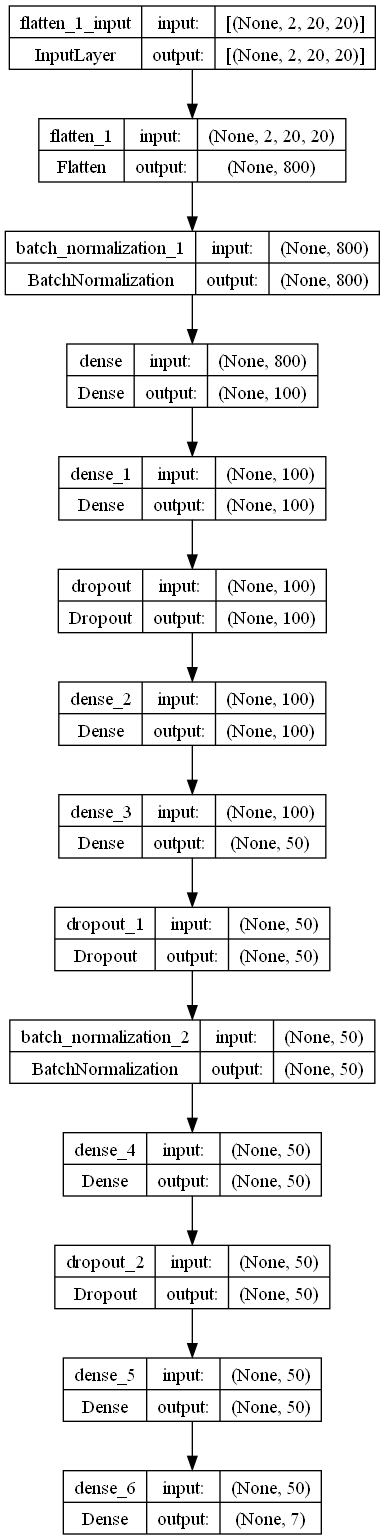

In [30]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [31]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [32]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [33]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [34]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [35]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [36]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 1s 6ms/step - loss: 12.4226 - a_1: 2.7823 - a_2: 2.7547 - b_1: 1.9512 - b_2: 2.0355 - d_1: 1.5380 - d_2: 1.5442 - n: 1.6876 - mean_metric: 0.4689 - val_loss: 11.5574 - val_a_1: 2.6103 - val_a_2: 2.6152 - val_b_1: 2.0806 - val_b_2: 1.9322 - val_d_1: 1.4395 - val_d_2: 1.6723 - val_n: 1.4782 - val_mean_metric: 0.4552 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 0s 3ms/step - loss: 10.3613 - a_1: 2.4048 - a_2: 2.3444 - b_1: 1.6881 - b_2: 1.6445 - d_1: 1.3488 - d_2: 1.3328 - n: 1.5113 - mean_metric: 0.4027 - val_loss: 9.5562 - val_a_1: 2.1631 - val_a_2: 2.0547 - val_b_1: 1.7305 - val_b_2: 1.7085 - val_d_1: 1.1793 - val_d_2: 1.3057 - val_n: 1.4392 - val_mean_metric: 0.3812 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 0s 3ms/step - loss: 9.2220 - a_1: 2.0765 - a_2: 2.0405 - b_1: 1.5938 - b_2: 1.5501 - d_1: 1.2947 - d_2: 1.2745 - n: 1.4177 - mean_metric: 0.3691 - val_loss: 8.0987 - val_a_1: 1.8383

70/70 [==============================] - 0s 3ms/step - loss: 4.4100 - a_1: 1.6767 - a_2: 1.6291 - b_1: 1.3620 - b_2: 1.3408 - d_1: 1.1225 - d_2: 1.1041 - n: 1.2774 - mean_metric: 0.3121 - val_loss: 3.7960 - val_a_1: 1.5287 - val_a_2: 1.4634 - val_b_1: 1.1762 - val_b_2: 1.1049 - val_d_1: 0.8344 - val_d_2: 0.8814 - val_n: 1.2601 - val_mean_metric: 0.2716 - lr: 0.0010
Epoch 23/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.3718 - a_1: 1.6638 - a_2: 1.6400 - b_1: 1.3767 - b_2: 1.3280 - d_1: 1.1325 - d_2: 1.1210 - n: 1.2939 - mean_metric: 0.3135 - val_loss: 3.8426 - val_a_1: 1.5549 - val_a_2: 1.5743 - val_b_1: 1.1924 - val_b_2: 1.1454 - val_d_1: 0.8879 - val_d_2: 0.8362 - val_n: 1.2645 - val_mean_metric: 0.2783 - lr: 0.0010
Epoch 24/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.2552 - a_1: 1.6666 - a_2: 1.6251 - b_1: 1.3462 - b_2: 1.3082 - d_1: 1.1115 - d_2: 1.1183 - n: 1.2834 - mean_metric: 0.3104 - val_loss: 3.7891 - val_a_1: 1.6521 - val_a_2: 1.

70/70 [==============================] - 0s 3ms/step - loss: 3.5539 - a_1: 1.6176 - a_2: 1.5684 - b_1: 1.3138 - b_2: 1.2769 - d_1: 1.0703 - d_2: 1.0806 - n: 1.2637 - mean_metric: 0.3016 - val_loss: 3.1543 - val_a_1: 1.4618 - val_a_2: 1.4527 - val_b_1: 1.2788 - val_b_2: 1.0694 - val_d_1: 0.9364 - val_d_2: 0.8529 - val_n: 1.2162 - val_mean_metric: 0.2722 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.5388 - a_1: 1.6009 - a_2: 1.5707 - b_1: 1.2974 - b_2: 1.2901 - d_1: 1.0793 - d_2: 1.0785 - n: 1.2573 - mean_metric: 0.3010 - val_loss: 3.1023 - val_a_1: 1.4854 - val_a_2: 1.4739 - val_b_1: 1.1417 - val_b_2: 1.1032 - val_d_1: 0.8429 - val_d_2: 0.8757 - val_n: 1.2260 - val_mean_metric: 0.2682 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.5080 - a_1: 1.6284 - a_2: 1.5461 - b_1: 1.2906 - b_2: 1.2733 - d_1: 1.0847 - d_2: 1.0746 - n: 1.2610 - mean_metric: 0.3005 - val_loss: 3.1078 - val_a_1: 1.5810 - val_a_2: 1.

70/70 [==============================] - 0s 3ms/step - loss: 3.2545 - a_1: 1.5760 - a_2: 1.5226 - b_1: 1.2511 - b_2: 1.2321 - d_1: 1.0315 - d_2: 1.0265 - n: 1.2444 - mean_metric: 0.2915 - val_loss: 2.8758 - val_a_1: 1.4273 - val_a_2: 1.4460 - val_b_1: 1.0703 - val_b_2: 1.1145 - val_d_1: 0.8805 - val_d_2: 0.8139 - val_n: 1.2095 - val_mean_metric: 0.2621 - lr: 0.0010
Epoch 65/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.2454 - a_1: 1.5491 - a_2: 1.5449 - b_1: 1.2465 - b_2: 1.2427 - d_1: 1.0368 - d_2: 1.0278 - n: 1.2418 - mean_metric: 0.2917 - val_loss: 2.8747 - val_a_1: 1.4261 - val_a_2: 1.4040 - val_b_1: 1.1324 - val_b_2: 1.1197 - val_d_1: 0.8685 - val_d_2: 0.8071 - val_n: 1.2015 - val_mean_metric: 0.2620 - lr: 0.0010
Epoch 66/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.2407 - a_1: 1.5731 - a_2: 1.5359 - b_1: 1.2450 - b_2: 1.2354 - d_1: 1.0430 - d_2: 1.0102 - n: 1.2448 - mean_metric: 0.2917 - val_loss: 2.9081 - val_a_1: 1.4213 - val_a_2: 1.

70/70 [==============================] - 0s 3ms/step - loss: 3.0683 - a_1: 1.5130 - a_2: 1.5004 - b_1: 1.2088 - b_2: 1.1872 - d_1: 1.0167 - d_2: 1.0141 - n: 1.2333 - mean_metric: 0.2846 - val_loss: 2.8476 - val_a_1: 1.4154 - val_a_2: 1.4311 - val_b_1: 1.1692 - val_b_2: 1.1074 - val_d_1: 0.8643 - val_d_2: 0.8116 - val_n: 1.2077 - val_mean_metric: 0.2636 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.1094 - a_1: 1.5446 - a_2: 1.4995 - b_1: 1.2185 - b_2: 1.2208 - d_1: 1.0065 - d_2: 1.0020 - n: 1.2376 - mean_metric: 0.2864 - val_loss: 2.8242 - val_a_1: 1.4261 - val_a_2: 1.4822 - val_b_1: 1.0619 - val_b_2: 1.0758 - val_d_1: 0.8507 - val_d_2: 0.8104 - val_n: 1.2100 - val_mean_metric: 0.2606 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.0771 - a_1: 1.5422 - a_2: 1.4859 - b_1: 1.2188 - b_2: 1.2041 - d_1: 0.9841 - d_2: 0.9988 - n: 1.2343 - mean_metric: 0.2844 - val_loss: 2.7478 - val_a_1: 1.4201 - val_a_2: 1.

70/70 [==============================] - 0s 3ms/step - loss: 2.9725 - a_1: 1.5080 - a_2: 1.4604 - b_1: 1.1919 - b_2: 1.2027 - d_1: 0.9673 - d_2: 0.9676 - n: 1.2238 - mean_metric: 0.2797 - val_loss: 2.7534 - val_a_1: 1.3821 - val_a_2: 1.4532 - val_b_1: 1.1079 - val_b_2: 1.0761 - val_d_1: 0.8540 - val_d_2: 0.8129 - val_n: 1.1896 - val_mean_metric: 0.2592 - lr: 0.0010
Epoch 107/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.9910 - a_1: 1.5199 - a_2: 1.4939 - b_1: 1.1941 - b_2: 1.1799 - d_1: 0.9798 - d_2: 0.9794 - n: 1.2237 - mean_metric: 0.2812 - val_loss: 2.8189 - val_a_1: 1.4338 - val_a_2: 1.4757 - val_b_1: 1.0818 - val_b_2: 1.1378 - val_d_1: 0.8944 - val_d_2: 0.8099 - val_n: 1.2024 - val_mean_metric: 0.2645 - lr: 0.0010
Epoch 108/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.9923 - a_1: 1.5121 - a_2: 1.4939 - b_1: 1.2105 - b_2: 1.1893 - d_1: 0.9750 - d_2: 0.9573 - n: 1.2217 - mean_metric: 0.2809 - val_loss: 2.7718 - val_a_1: 1.4196 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.8850 - a_1: 1.4906 - a_2: 1.4353 - b_1: 1.1771 - b_2: 1.1574 - d_1: 0.9590 - d_2: 0.9606 - n: 1.2086 - mean_metric: 0.2752 - val_loss: 2.8038 - val_a_1: 1.4168 - val_a_2: 1.4923 - val_b_1: 1.1035 - val_b_2: 1.0506 - val_d_1: 0.8973 - val_d_2: 0.8271 - val_n: 1.1907 - val_mean_metric: 0.2626 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8917 - a_1: 1.4864 - a_2: 1.4625 - b_1: 1.1724 - b_2: 1.1676 - d_1: 0.9593 - d_2: 0.9590 - n: 1.1984 - mean_metric: 0.2757 - val_loss: 2.6995 - val_a_1: 1.3746 - val_a_2: 1.4500 - val_b_1: 1.0307 - val_b_2: 1.0359 - val_d_1: 0.8913 - val_d_2: 0.8385 - val_n: 1.1808 - val_mean_metric: 0.2568 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8935 - a_1: 1.4874 - a_2: 1.4707 - b_1: 1.1807 - b_2: 1.1856 - d_1: 0.9322 - d_2: 0.9471 - n: 1.2098 - mean_metric: 0.2761 - val_loss: 2.7390 - val_a_1: 1.3874 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.9014 - a_1: 1.5056 - a_2: 1.4883 - b_1: 1.1765 - b_2: 1.1780 - d_1: 0.9384 - d_2: 0.9419 - n: 1.2039 - mean_metric: 0.2767 - val_loss: 2.6973 - val_a_1: 1.3731 - val_a_2: 1.4641 - val_b_1: 1.0459 - val_b_2: 1.0578 - val_d_1: 0.8279 - val_d_2: 0.8554 - val_n: 1.1748 - val_mean_metric: 0.2567 - lr: 0.0010
Epoch 149/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8656 - a_1: 1.4792 - a_2: 1.4752 - b_1: 1.1746 - b_2: 1.1667 - d_1: 0.9418 - d_2: 0.9364 - n: 1.2019 - mean_metric: 0.2748 - val_loss: 2.6809 - val_a_1: 1.4047 - val_a_2: 1.4541 - val_b_1: 1.0767 - val_b_2: 1.0123 - val_d_1: 0.7999 - val_d_2: 0.8276 - val_n: 1.1835 - val_mean_metric: 0.2554 - lr: 0.0010
Epoch 150/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8577 - a_1: 1.4814 - a_2: 1.4640 - b_1: 1.1601 - b_2: 1.1675 - d_1: 0.9258 - d_2: 0.9707 - n: 1.1995 - mean_metric: 0.2746 - val_loss: 2.7696 - val_a_1: 1.4133 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.8207 - a_1: 1.4886 - a_2: 1.4557 - b_1: 1.1548 - b_2: 1.1581 - d_1: 0.9353 - d_2: 0.9518 - n: 1.1918 - mean_metric: 0.2735 - val_loss: 2.6442 - val_a_1: 1.3808 - val_a_2: 1.4635 - val_b_1: 1.0509 - val_b_2: 1.0321 - val_d_1: 0.8584 - val_d_2: 0.8337 - val_n: 1.1490 - val_mean_metric: 0.2557 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8557 - a_1: 1.4871 - a_2: 1.4605 - b_1: 1.1957 - b_2: 1.1612 - d_1: 0.9346 - d_2: 0.9424 - n: 1.1951 - mean_metric: 0.2748 - val_loss: 2.6555 - val_a_1: 1.4330 - val_a_2: 1.3948 - val_b_1: 1.0438 - val_b_2: 1.0214 - val_d_1: 0.7979 - val_d_2: 0.8873 - val_n: 1.1756 - val_mean_metric: 0.2552 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8679 - a_1: 1.4880 - a_2: 1.4714 - b_1: 1.1813 - b_2: 1.1659 - d_1: 0.9399 - d_2: 0.9540 - n: 1.1893 - mean_metric: 0.2752 - val_loss: 2.7643 - val_a_1: 1.3954 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.8208 - a_1: 1.4570 - a_2: 1.4665 - b_1: 1.1571 - b_2: 1.1572 - d_1: 0.9567 - d_2: 0.9521 - n: 1.1861 - mean_metric: 0.2734 - val_loss: 2.6251 - val_a_1: 1.3869 - val_a_2: 1.3963 - val_b_1: 1.0362 - val_b_2: 1.0223 - val_d_1: 0.8947 - val_d_2: 0.8403 - val_n: 1.1558 - val_mean_metric: 0.2545 - lr: 0.0010
Epoch 191/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8003 - a_1: 1.4851 - a_2: 1.4374 - b_1: 1.1544 - b_2: 1.1501 - d_1: 0.9375 - d_2: 0.9428 - n: 1.1852 - mean_metric: 0.2721 - val_loss: 2.5766 - val_a_1: 1.3646 - val_a_2: 1.4273 - val_b_1: 1.0247 - val_b_2: 1.0407 - val_d_1: 0.8152 - val_d_2: 0.8069 - val_n: 1.1487 - val_mean_metric: 0.2510 - lr: 0.0010
Epoch 192/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8169 - a_1: 1.4750 - a_2: 1.4504 - b_1: 1.1587 - b_2: 1.1497 - d_1: 0.9439 - d_2: 0.9446 - n: 1.1890 - mean_metric: 0.2728 - val_loss: 2.8050 - val_a_1: 1.3943 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7926 - a_1: 1.4730 - a_2: 1.4581 - b_1: 1.1590 - b_2: 1.1503 - d_1: 0.9373 - d_2: 0.9411 - n: 1.1827 - mean_metric: 0.2724 - val_loss: 2.7827 - val_a_1: 1.4683 - val_a_2: 1.4506 - val_b_1: 1.1247 - val_b_2: 1.0799 - val_d_1: 0.8955 - val_d_2: 0.8196 - val_n: 1.1765 - val_mean_metric: 0.2638 - lr: 0.0010
Epoch 212/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8151 - a_1: 1.4586 - a_2: 1.4818 - b_1: 1.1534 - b_2: 1.1415 - d_1: 0.9445 - d_2: 0.9480 - n: 1.1842 - mean_metric: 0.2727 - val_loss: 2.6420 - val_a_1: 1.3933 - val_a_2: 1.4550 - val_b_1: 1.0358 - val_b_2: 1.0683 - val_d_1: 0.8070 - val_d_2: 0.8173 - val_n: 1.1636 - val_mean_metric: 0.2548 - lr: 0.0010
Epoch 213/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8198 - a_1: 1.4730 - a_2: 1.4502 - b_1: 1.1632 - b_2: 1.1729 - d_1: 0.9506 - d_2: 0.9485 - n: 1.1830 - mean_metric: 0.2737 - val_loss: 2.6756 - val_a_1: 1.3679 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7684 - a_1: 1.4517 - a_2: 1.4416 - b_1: 1.1417 - b_2: 1.1532 - d_1: 0.9445 - d_2: 0.9484 - n: 1.1742 - mean_metric: 0.2709 - val_loss: 2.6000 - val_a_1: 1.3981 - val_a_2: 1.4164 - val_b_1: 1.0358 - val_b_2: 1.0517 - val_d_1: 0.8026 - val_d_2: 0.8282 - val_n: 1.1387 - val_mean_metric: 0.2525 - lr: 0.0010
Epoch 233/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.8030 - a_1: 1.4885 - a_2: 1.4436 - b_1: 1.1451 - b_2: 1.1703 - d_1: 0.9406 - d_2: 0.9457 - n: 1.1749 - mean_metric: 0.2726 - val_loss: 2.7633 - val_a_1: 1.4120 - val_a_2: 1.5233 - val_b_1: 1.0298 - val_b_2: 1.1249 - val_d_1: 0.8541 - val_d_2: 0.8816 - val_n: 1.1713 - val_mean_metric: 0.2632 - lr: 0.0010
Epoch 234/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7882 - a_1: 1.4832 - a_2: 1.4695 - b_1: 1.1385 - b_2: 1.1447 - d_1: 0.9358 - d_2: 0.9364 - n: 1.1847 - mean_metric: 0.2721 - val_loss: 2.6567 - val_a_1: 1.3686 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7819 - a_1: 1.4728 - a_2: 1.4464 - b_1: 1.1372 - b_2: 1.1379 - d_1: 0.9289 - d_2: 0.9456 - n: 1.1769 - mean_metric: 0.2706 - val_loss: 2.5891 - val_a_1: 1.3598 - val_a_2: 1.4148 - val_b_1: 1.0299 - val_b_2: 1.0180 - val_d_1: 0.8406 - val_d_2: 0.8493 - val_n: 1.1468 - val_mean_metric: 0.2521 - lr: 0.0010
Epoch 254/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7635 - a_1: 1.4720 - a_2: 1.4554 - b_1: 1.1478 - b_2: 1.1297 - d_1: 0.9373 - d_2: 0.9242 - n: 1.1784 - mean_metric: 0.2706 - val_loss: 2.5867 - val_a_1: 1.3754 - val_a_2: 1.3940 - val_b_1: 1.0423 - val_b_2: 1.0363 - val_d_1: 0.8051 - val_d_2: 0.8236 - val_n: 1.1541 - val_mean_metric: 0.2511 - lr: 0.0010
Epoch 255/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7710 - a_1: 1.4725 - a_2: 1.4479 - b_1: 1.1552 - b_2: 1.1561 - d_1: 0.9468 - d_2: 0.9295 - n: 1.1762 - mean_metric: 0.2718 - val_loss: 2.7192 - val_a_1: 1.4091 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7470 - a_1: 1.4671 - a_2: 1.4318 - b_1: 1.1435 - b_2: 1.1367 - d_1: 0.9282 - d_2: 0.9344 - n: 1.1771 - mean_metric: 0.2697 - val_loss: 2.5532 - val_a_1: 1.3577 - val_a_2: 1.4087 - val_b_1: 1.0736 - val_b_2: 1.0220 - val_d_1: 0.8284 - val_d_2: 0.8089 - val_n: 1.1374 - val_mean_metric: 0.2513 - lr: 0.0010
Epoch 275/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7062 - a_1: 1.4529 - a_2: 1.4115 - b_1: 1.1358 - b_2: 1.1349 - d_1: 0.9222 - d_2: 0.9319 - n: 1.1703 - mean_metric: 0.2678 - val_loss: 2.5135 - val_a_1: 1.3643 - val_a_2: 1.3744 - val_b_1: 1.0201 - val_b_2: 1.0671 - val_d_1: 0.8179 - val_d_2: 0.7913 - val_n: 1.1217 - val_mean_metric: 0.2487 - lr: 0.0010
Epoch 276/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7311 - a_1: 1.4493 - a_2: 1.4311 - b_1: 1.1404 - b_2: 1.1405 - d_1: 0.9580 - d_2: 0.9349 - n: 1.1649 - mean_metric: 0.2697 - val_loss: 2.6024 - val_a_1: 1.3928 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7487 - a_1: 1.4682 - a_2: 1.4377 - b_1: 1.1421 - b_2: 1.1506 - d_1: 0.9263 - d_2: 0.9287 - n: 1.1685 - mean_metric: 0.2698 - val_loss: 2.7261 - val_a_1: 1.3828 - val_a_2: 1.4889 - val_b_1: 1.0462 - val_b_2: 1.0832 - val_d_1: 1.0428 - val_d_2: 0.8072 - val_n: 1.1364 - val_mean_metric: 0.2629 - lr: 0.0010
Epoch 296/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7337 - a_1: 1.4433 - a_2: 1.4287 - b_1: 1.1311 - b_2: 1.1444 - d_1: 0.9452 - d_2: 0.9422 - n: 1.1642 - mean_metric: 0.2690 - val_loss: 2.6853 - val_a_1: 1.3948 - val_a_2: 1.4660 - val_b_1: 1.0942 - val_b_2: 1.0613 - val_d_1: 0.8281 - val_d_2: 0.8362 - val_n: 1.1492 - val_mean_metric: 0.2577 - lr: 0.0010
Epoch 297/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7313 - a_1: 1.4626 - a_2: 1.4384 - b_1: 1.1422 - b_2: 1.1214 - d_1: 0.9283 - d_2: 0.9132 - n: 1.1836 - mean_metric: 0.2688 - val_loss: 2.6733 - val_a_1: 1.4071 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7006 - a_1: 1.4434 - a_2: 1.4350 - b_1: 1.1287 - b_2: 1.1213 - d_1: 0.9382 - d_2: 0.9171 - n: 1.1681 - mean_metric: 0.2675 - val_loss: 2.6172 - val_a_1: 1.3648 - val_a_2: 1.4536 - val_b_1: 1.0563 - val_b_2: 1.0770 - val_d_1: 0.8215 - val_d_2: 0.8035 - val_n: 1.1503 - val_mean_metric: 0.2543 - lr: 0.0010
Epoch 317/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7367 - a_1: 1.4507 - a_2: 1.4383 - b_1: 1.1577 - b_2: 1.1421 - d_1: 0.9440 - d_2: 0.9272 - n: 1.1663 - mean_metric: 0.2699 - val_loss: 2.5928 - val_a_1: 1.3886 - val_a_2: 1.4061 - val_b_1: 1.0478 - val_b_2: 1.0239 - val_d_1: 0.7981 - val_d_2: 0.8420 - val_n: 1.1496 - val_mean_metric: 0.2520 - lr: 0.0010
Epoch 318/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7280 - a_1: 1.4556 - a_2: 1.4237 - b_1: 1.1281 - b_2: 1.1484 - d_1: 0.9460 - d_2: 0.9340 - n: 1.1695 - mean_metric: 0.2693 - val_loss: 2.5868 - val_a_1: 1.3507 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7329 - a_1: 1.4727 - a_2: 1.4473 - b_1: 1.1425 - b_2: 1.1464 - d_1: 0.9269 - d_2: 0.9171 - n: 1.1705 - mean_metric: 0.2698 - val_loss: 2.5671 - val_a_1: 1.3792 - val_a_2: 1.4314 - val_b_1: 1.0302 - val_b_2: 1.0106 - val_d_1: 0.7964 - val_d_2: 0.8132 - val_n: 1.1425 - val_mean_metric: 0.2503 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7138 - a_1: 1.4544 - a_2: 1.4267 - b_1: 1.1478 - b_2: 1.1177 - d_1: 0.9410 - d_2: 0.9434 - n: 1.1603 - mean_metric: 0.2688 - val_loss: 2.6161 - val_a_1: 1.3685 - val_a_2: 1.4116 - val_b_1: 1.1135 - val_b_2: 1.0558 - val_d_1: 0.8834 - val_d_2: 0.8044 - val_n: 1.1410 - val_mean_metric: 0.2560 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7136 - a_1: 1.4558 - a_2: 1.4388 - b_1: 1.1455 - b_2: 1.1221 - d_1: 0.9301 - d_2: 0.9299 - n: 1.1618 - mean_metric: 0.2685 - val_loss: 2.5425 - val_a_1: 1.3482 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7362 - a_1: 1.4664 - a_2: 1.4253 - b_1: 1.1485 - b_2: 1.1238 - d_1: 0.9322 - d_2: 0.9521 - n: 1.1656 - mean_metric: 0.2695 - val_loss: 2.5029 - val_a_1: 1.3672 - val_a_2: 1.3891 - val_b_1: 1.0196 - val_b_2: 0.9925 - val_d_1: 0.8024 - val_d_2: 0.8164 - val_n: 1.1234 - val_mean_metric: 0.2472 - lr: 0.0010
Epoch 359/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7562 - a_1: 1.4762 - a_2: 1.4225 - b_1: 1.1762 - b_2: 1.1396 - d_1: 0.9472 - d_2: 0.9108 - n: 1.1660 - mean_metric: 0.2703 - val_loss: 2.6447 - val_a_1: 1.4073 - val_a_2: 1.4656 - val_b_1: 1.0405 - val_b_2: 1.0147 - val_d_1: 0.8540 - val_d_2: 0.7996 - val_n: 1.1475 - val_mean_metric: 0.2544 - lr: 0.0010
Epoch 360/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7587 - a_1: 1.4723 - a_2: 1.4319 - b_1: 1.1641 - b_2: 1.1407 - d_1: 0.9484 - d_2: 0.9268 - n: 1.1712 - mean_metric: 0.2709 - val_loss: 2.5375 - val_a_1: 1.3472 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.7265 - a_1: 1.4750 - a_2: 1.4322 - b_1: 1.1394 - b_2: 1.1327 - d_1: 0.9193 - d_2: 0.9209 - n: 1.1682 - mean_metric: 0.2687 - val_loss: 2.6521 - val_a_1: 1.3714 - val_a_2: 1.5144 - val_b_1: 1.0223 - val_b_2: 1.0741 - val_d_1: 0.8565 - val_d_2: 0.8139 - val_n: 1.1435 - val_mean_metric: 0.2566 - lr: 0.0010
Epoch 380/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7229 - a_1: 1.4522 - a_2: 1.4481 - b_1: 1.1435 - b_2: 1.1156 - d_1: 0.9212 - d_2: 0.9258 - n: 1.1641 - mean_metric: 0.2681 - val_loss: 2.5517 - val_a_1: 1.3723 - val_a_2: 1.3928 - val_b_1: 1.0412 - val_b_2: 1.0084 - val_d_1: 0.8344 - val_d_2: 0.8496 - val_n: 1.1277 - val_mean_metric: 0.2510 - lr: 0.0010
Epoch 381/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7744 - a_1: 1.4908 - a_2: 1.4557 - b_1: 1.1418 - b_2: 1.1313 - d_1: 0.9248 - d_2: 0.9372 - n: 1.1606 - mean_metric: 0.2705 - val_loss: 2.5981 - val_a_1: 1.3502 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.6897 - a_1: 1.4527 - a_2: 1.4056 - b_1: 1.1397 - b_2: 1.1157 - d_1: 0.9291 - d_2: 0.9191 - n: 1.1612 - mean_metric: 0.2666 - val_loss: 2.7249 - val_a_1: 1.4324 - val_a_2: 1.4665 - val_b_1: 1.0530 - val_b_2: 1.1353 - val_d_1: 0.9816 - val_d_2: 0.8115 - val_n: 1.1429 - val_mean_metric: 0.2640 - lr: 0.0010
Epoch 401/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7113 - a_1: 1.4681 - a_2: 1.4271 - b_1: 1.1266 - b_2: 1.1252 - d_1: 0.9341 - d_2: 0.9207 - n: 1.1543 - mean_metric: 0.2676 - val_loss: 2.6058 - val_a_1: 1.3847 - val_a_2: 1.4245 - val_b_1: 1.0499 - val_b_2: 1.0366 - val_d_1: 0.8178 - val_d_2: 0.8578 - val_n: 1.1328 - val_mean_metric: 0.2536 - lr: 0.0010
Epoch 402/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7244 - a_1: 1.4613 - a_2: 1.4354 - b_1: 1.1568 - b_2: 1.1142 - d_1: 0.9296 - d_2: 0.9320 - n: 1.1560 - mean_metric: 0.2687 - val_loss: 2.5913 - val_a_1: 1.3648 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 2.6921 - a_1: 1.4830 - a_2: 1.4013 - b_1: 1.1370 - b_2: 1.1149 - d_1: 0.9303 - d_2: 0.9084 - n: 1.1525 - mean_metric: 0.2667 - val_loss: 2.5446 - val_a_1: 1.3849 - val_a_2: 1.3920 - val_b_1: 1.0245 - val_b_2: 1.0857 - val_d_1: 0.7901 - val_d_2: 0.7867 - val_n: 1.1288 - val_mean_metric: 0.2499 - lr: 9.6700e-04
Epoch 422/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7064 - a_1: 1.4709 - a_2: 1.4249 - b_1: 1.1329 - b_2: 1.1325 - d_1: 0.9328 - d_2: 0.9186 - n: 1.1569 - mean_metric: 0.2681 - val_loss: 2.6349 - val_a_1: 1.4309 - val_a_2: 1.4482 - val_b_1: 1.0292 - val_b_2: 1.0345 - val_d_1: 0.8424 - val_d_2: 0.8379 - val_n: 1.1461 - val_mean_metric: 0.2557 - lr: 9.6535e-04
Epoch 423/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6969 - a_1: 1.4540 - a_2: 1.4412 - b_1: 1.1253 - b_2: 1.1203 - d_1: 0.9334 - d_2: 0.9139 - n: 1.1567 - mean_metric: 0.2673 - val_loss: 2.6069 - val_a_1: 1.3792 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.7006 - a_1: 1.4576 - a_2: 1.4203 - b_1: 1.1227 - b_2: 1.1345 - d_1: 0.9373 - d_2: 0.9337 - n: 1.1520 - mean_metric: 0.2677 - val_loss: 2.6420 - val_a_1: 1.3642 - val_a_2: 1.4745 - val_b_1: 1.0500 - val_b_2: 1.0330 - val_d_1: 0.9096 - val_d_2: 0.8148 - val_n: 1.1337 - val_mean_metric: 0.2561 - lr: 9.3235e-04
Epoch 443/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.7155 - a_1: 1.4580 - a_2: 1.4338 - b_1: 1.1426 - b_2: 1.1273 - d_1: 0.9239 - d_2: 0.9179 - n: 1.1560 - mean_metric: 0.2678 - val_loss: 2.5579 - val_a_1: 1.3686 - val_a_2: 1.3824 - val_b_1: 1.0265 - val_b_2: 1.0172 - val_d_1: 0.8616 - val_d_2: 0.9090 - val_n: 1.1113 - val_mean_metric: 0.2527 - lr: 9.3070e-04
Epoch 444/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6838 - a_1: 1.4681 - a_2: 1.4178 - b_1: 1.1325 - b_2: 1.1215 - d_1: 0.9207 - d_2: 0.9207 - n: 1.1536 - mean_metric: 0.2670 - val_loss: 2.4956 - val_a_1: 1.3576 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.6474 - a_1: 1.4366 - a_2: 1.4253 - b_1: 1.1180 - b_2: 1.1038 - d_1: 0.9350 - d_2: 0.9087 - n: 1.1438 - mean_metric: 0.2649 - val_loss: 2.4798 - val_a_1: 1.3619 - val_a_2: 1.3417 - val_b_1: 1.0831 - val_b_2: 1.0128 - val_d_1: 0.8288 - val_d_2: 0.8074 - val_n: 1.0922 - val_mean_metric: 0.2478 - lr: 8.9770e-04
Epoch 464/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6412 - a_1: 1.4309 - a_2: 1.4005 - b_1: 1.1335 - b_2: 1.1088 - d_1: 0.9185 - d_2: 0.9231 - n: 1.1464 - mean_metric: 0.2645 - val_loss: 2.5693 - val_a_1: 1.3825 - val_a_2: 1.3705 - val_b_1: 1.1279 - val_b_2: 1.0537 - val_d_1: 0.8210 - val_d_2: 0.8031 - val_n: 1.1174 - val_mean_metric: 0.2526 - lr: 8.9605e-04
Epoch 465/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6694 - a_1: 1.4516 - a_2: 1.4026 - b_1: 1.1310 - b_2: 1.1015 - d_1: 0.9375 - d_2: 0.9339 - n: 1.1379 - mean_metric: 0.2656 - val_loss: 2.4662 - val_a_1: 1.3425 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.6788 - a_1: 1.4440 - a_2: 1.4225 - b_1: 1.1221 - b_2: 1.1213 - d_1: 0.9417 - d_2: 0.9072 - n: 1.1412 - mean_metric: 0.2657 - val_loss: 2.4830 - val_a_1: 1.3443 - val_a_2: 1.3431 - val_b_1: 1.0300 - val_b_2: 1.0310 - val_d_1: 0.8658 - val_d_2: 0.8332 - val_n: 1.0903 - val_mean_metric: 0.2481 - lr: 8.6305e-04
Epoch 485/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6717 - a_1: 1.4614 - a_2: 1.4124 - b_1: 1.1425 - b_2: 1.1238 - d_1: 0.9219 - d_2: 0.9128 - n: 1.1408 - mean_metric: 0.2663 - val_loss: 2.4914 - val_a_1: 1.3545 - val_a_2: 1.3637 - val_b_1: 1.0273 - val_b_2: 1.0020 - val_d_1: 0.8069 - val_d_2: 0.8177 - val_n: 1.0989 - val_mean_metric: 0.2459 - lr: 8.6140e-04
Epoch 486/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6391 - a_1: 1.4453 - a_2: 1.3989 - b_1: 1.1166 - b_2: 1.1085 - d_1: 0.9358 - d_2: 0.9072 - n: 1.1457 - mean_metric: 0.2644 - val_loss: 2.5758 - val_a_1: 1.3622 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.6498 - a_1: 1.4524 - a_2: 1.4085 - b_1: 1.1287 - b_2: 1.1189 - d_1: 0.9157 - d_2: 0.9171 - n: 1.1384 - mean_metric: 0.2651 - val_loss: 2.4709 - val_a_1: 1.3329 - val_a_2: 1.3550 - val_b_1: 1.0812 - val_b_2: 0.9986 - val_d_1: 0.7924 - val_d_2: 0.7893 - val_n: 1.0936 - val_mean_metric: 0.2450 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6523 - a_1: 1.4406 - a_2: 1.4105 - b_1: 1.1284 - b_2: 1.1128 - d_1: 0.9208 - d_2: 0.9125 - n: 1.1408 - mean_metric: 0.2647 - val_loss: 2.5361 - val_a_1: 1.3420 - val_a_2: 1.4303 - val_b_1: 1.0144 - val_b_2: 1.0109 - val_d_1: 0.8591 - val_d_2: 0.8263 - val_n: 1.0989 - val_mean_metric: 0.2496 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6424 - a_1: 1.4377 - a_2: 1.4048 - b_1: 1.1366 - b_2: 1.1060 - d_1: 0.9137 - d_2: 0.9149 - n: 1.1307 - mean_metric: 0.2639 - val_loss: 2.5049 - val_a_1: 1.3804 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.6237 - a_1: 1.4507 - a_2: 1.4081 - b_1: 1.1292 - b_2: 1.0989 - d_1: 0.9154 - d_2: 0.8934 - n: 1.1349 - mean_metric: 0.2635 - val_loss: 2.4974 - val_a_1: 1.3540 - val_a_2: 1.4270 - val_b_1: 1.0117 - val_b_2: 1.0225 - val_d_1: 0.7935 - val_d_2: 0.7995 - val_n: 1.0931 - val_mean_metric: 0.2469 - lr: 7.9375e-04
Epoch 527/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6507 - a_1: 1.4516 - a_2: 1.4268 - b_1: 1.1034 - b_2: 1.1522 - d_1: 0.9201 - d_2: 0.9051 - n: 1.1429 - mean_metric: 0.2658 - val_loss: 2.4405 - val_a_1: 1.3709 - val_a_2: 1.3393 - val_b_1: 0.9965 - val_b_2: 0.9881 - val_d_1: 0.8650 - val_d_2: 0.7881 - val_n: 1.0986 - val_mean_metric: 0.2451 - lr: 7.9210e-04
Epoch 528/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6285 - a_1: 1.4496 - a_2: 1.4203 - b_1: 1.1155 - b_2: 1.1053 - d_1: 0.9099 - d_2: 0.8984 - n: 1.1345 - mean_metric: 0.2636 - val_loss: 2.4902 - val_a_1: 1.3448 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.6271 - a_1: 1.4590 - a_2: 1.4146 - b_1: 1.1216 - b_2: 1.1086 - d_1: 0.9198 - d_2: 0.8966 - n: 1.1234 - mean_metric: 0.2640 - val_loss: 2.4330 - val_a_1: 1.3617 - val_a_2: 1.3044 - val_b_1: 1.0262 - val_b_2: 1.0165 - val_d_1: 0.8220 - val_d_2: 0.8319 - val_n: 1.0719 - val_mean_metric: 0.2447 - lr: 7.5910e-04
Epoch 548/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6190 - a_1: 1.4334 - a_2: 1.3883 - b_1: 1.1229 - b_2: 1.1030 - d_1: 0.9172 - d_2: 0.9294 - n: 1.1297 - mean_metric: 0.2633 - val_loss: 2.4963 - val_a_1: 1.3607 - val_a_2: 1.3414 - val_b_1: 1.0434 - val_b_2: 1.0093 - val_d_1: 0.8764 - val_d_2: 0.8165 - val_n: 1.0856 - val_mean_metric: 0.2479 - lr: 7.5745e-04
Epoch 549/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6005 - a_1: 1.4260 - a_2: 1.3882 - b_1: 1.1208 - b_2: 1.1071 - d_1: 0.9124 - d_2: 0.8938 - n: 1.1216 - mean_metric: 0.2615 - val_loss: 2.4910 - val_a_1: 1.3653 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5982 - a_1: 1.4395 - a_2: 1.4009 - b_1: 1.1042 - b_2: 1.1161 - d_1: 0.9077 - d_2: 0.9025 - n: 1.1225 - mean_metric: 0.2624 - val_loss: 2.4052 - val_a_1: 1.3441 - val_a_2: 1.3667 - val_b_1: 1.0052 - val_b_2: 0.9967 - val_d_1: 0.7833 - val_d_2: 0.8113 - val_n: 1.0624 - val_mean_metric: 0.2426 - lr: 7.2445e-04
Epoch 569/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6132 - a_1: 1.4476 - a_2: 1.4070 - b_1: 1.1040 - b_2: 1.1173 - d_1: 0.9268 - d_2: 0.9071 - n: 1.1192 - mean_metric: 0.2634 - val_loss: 2.4835 - val_a_1: 1.3863 - val_a_2: 1.3271 - val_b_1: 1.0391 - val_b_2: 1.0041 - val_d_1: 0.8876 - val_d_2: 0.8227 - val_n: 1.0820 - val_mean_metric: 0.2484 - lr: 7.2280e-04
Epoch 570/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.6253 - a_1: 1.4482 - a_2: 1.4181 - b_1: 1.1397 - b_2: 1.0937 - d_1: 0.9203 - d_2: 0.9079 - n: 1.1226 - mean_metric: 0.2642 - val_loss: 2.4684 - val_a_1: 1.3659 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5981 - a_1: 1.4306 - a_2: 1.3934 - b_1: 1.1131 - b_2: 1.0912 - d_1: 0.9050 - d_2: 0.9101 - n: 1.1171 - mean_metric: 0.2612 - val_loss: 2.4176 - val_a_1: 1.3531 - val_a_2: 1.3236 - val_b_1: 1.0149 - val_b_2: 0.9882 - val_d_1: 0.8762 - val_d_2: 0.8072 - val_n: 1.0572 - val_mean_metric: 0.2442 - lr: 6.8980e-04
Epoch 590/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5890 - a_1: 1.4319 - a_2: 1.4010 - b_1: 1.0998 - b_2: 1.0977 - d_1: 0.9058 - d_2: 0.8972 - n: 1.1164 - mean_metric: 0.2609 - val_loss: 2.4907 - val_a_1: 1.3770 - val_a_2: 1.3787 - val_b_1: 1.0047 - val_b_2: 0.9953 - val_d_1: 0.8051 - val_d_2: 0.7942 - val_n: 1.0971 - val_mean_metric: 0.2453 - lr: 6.8815e-04
Epoch 591/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5757 - a_1: 1.4255 - a_2: 1.3794 - b_1: 1.1145 - b_2: 1.0953 - d_1: 0.9143 - d_2: 0.9104 - n: 1.1131 - mean_metric: 0.2609 - val_loss: 2.3966 - val_a_1: 1.3404 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5742 - a_1: 1.4268 - a_2: 1.4003 - b_1: 1.1170 - b_2: 1.0750 - d_1: 0.9049 - d_2: 0.8926 - n: 1.1171 - mean_metric: 0.2603 - val_loss: 2.3828 - val_a_1: 1.3527 - val_a_2: 1.3072 - val_b_1: 1.0066 - val_b_2: 0.9738 - val_d_1: 0.8032 - val_d_2: 0.8208 - val_n: 1.0539 - val_mean_metric: 0.2409 - lr: 6.5515e-04
Epoch 611/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5558 - a_1: 1.4188 - a_2: 1.3697 - b_1: 1.1019 - b_2: 1.0877 - d_1: 0.9251 - d_2: 0.9061 - n: 1.1069 - mean_metric: 0.2597 - val_loss: 2.4038 - val_a_1: 1.3456 - val_a_2: 1.3105 - val_b_1: 1.0149 - val_b_2: 1.0427 - val_d_1: 0.7813 - val_d_2: 0.8275 - val_n: 1.0562 - val_mean_metric: 0.2428 - lr: 6.5350e-04
Epoch 612/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5696 - a_1: 1.4333 - a_2: 1.3989 - b_1: 1.0988 - b_2: 1.0973 - d_1: 0.8912 - d_2: 0.8869 - n: 1.1133 - mean_metric: 0.2598 - val_loss: 2.4122 - val_a_1: 1.3239 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5905 - a_1: 1.4374 - a_2: 1.4094 - b_1: 1.1100 - b_2: 1.0910 - d_1: 0.9088 - d_2: 0.8962 - n: 1.1157 - mean_metric: 0.2615 - val_loss: 2.4218 - val_a_1: 1.3360 - val_a_2: 1.3520 - val_b_1: 1.0289 - val_b_2: 1.0089 - val_d_1: 0.8011 - val_d_2: 0.7896 - val_n: 1.0628 - val_mean_metric: 0.2429 - lr: 6.2050e-04
Epoch 632/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5805 - a_1: 1.4477 - a_2: 1.3902 - b_1: 1.1305 - b_2: 1.0944 - d_1: 0.9110 - d_2: 0.8989 - n: 1.1046 - mean_metric: 0.2618 - val_loss: 2.4093 - val_a_1: 1.3482 - val_a_2: 1.3134 - val_b_1: 0.9868 - val_b_2: 1.0106 - val_d_1: 0.8161 - val_d_2: 0.8084 - val_n: 1.0615 - val_mean_metric: 0.2417 - lr: 6.1885e-04
Epoch 633/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5791 - a_1: 1.4421 - a_2: 1.4018 - b_1: 1.0949 - b_2: 1.1060 - d_1: 0.9102 - d_2: 0.8953 - n: 1.1070 - mean_metric: 0.2611 - val_loss: 2.4716 - val_a_1: 1.3788 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5608 - a_1: 1.4351 - a_2: 1.3890 - b_1: 1.1129 - b_2: 1.0893 - d_1: 0.9089 - d_2: 0.8977 - n: 1.1051 - mean_metric: 0.2605 - val_loss: 2.3659 - val_a_1: 1.3405 - val_a_2: 1.2841 - val_b_1: 1.0058 - val_b_2: 0.9728 - val_d_1: 0.7754 - val_d_2: 0.8193 - val_n: 1.0537 - val_mean_metric: 0.2387 - lr: 5.8585e-04
Epoch 653/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5313 - a_1: 1.4082 - a_2: 1.3848 - b_1: 1.0900 - b_2: 1.0756 - d_1: 0.9064 - d_2: 0.8979 - n: 1.1078 - mean_metric: 0.2583 - val_loss: 2.3700 - val_a_1: 1.3435 - val_a_2: 1.3129 - val_b_1: 1.0076 - val_b_2: 0.9896 - val_d_1: 0.7832 - val_d_2: 0.8260 - val_n: 1.0453 - val_mean_metric: 0.2405 - lr: 5.8420e-04
Epoch 654/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5846 - a_1: 1.4296 - a_2: 1.3890 - b_1: 1.1228 - b_2: 1.0973 - d_1: 0.9082 - d_2: 0.9111 - n: 1.0960 - mean_metric: 0.2610 - val_loss: 2.3879 - val_a_1: 1.3136 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5459 - a_1: 1.4160 - a_2: 1.3837 - b_1: 1.1129 - b_2: 1.0944 - d_1: 0.9041 - d_2: 0.9034 - n: 1.0882 - mean_metric: 0.2592 - val_loss: 2.3918 - val_a_1: 1.3502 - val_a_2: 1.3169 - val_b_1: 0.9838 - val_b_2: 1.0459 - val_d_1: 0.8004 - val_d_2: 0.7903 - val_n: 1.0369 - val_mean_metric: 0.2411 - lr: 5.5120e-04
Epoch 674/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5435 - a_1: 1.4266 - a_2: 1.3839 - b_1: 1.0950 - b_2: 1.0912 - d_1: 0.8859 - d_2: 0.9092 - n: 1.0961 - mean_metric: 0.2588 - val_loss: 2.4221 - val_a_1: 1.3641 - val_a_2: 1.3499 - val_b_1: 1.0456 - val_b_2: 0.9678 - val_d_1: 0.7924 - val_d_2: 0.8143 - val_n: 1.0499 - val_mean_metric: 0.2430 - lr: 5.4955e-04
Epoch 675/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5427 - a_1: 1.4232 - a_2: 1.3870 - b_1: 1.0937 - b_2: 1.1002 - d_1: 0.8932 - d_2: 0.9078 - n: 1.0908 - mean_metric: 0.2592 - val_loss: 2.3888 - val_a_1: 1.3679 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5352 - a_1: 1.4274 - a_2: 1.3704 - b_1: 1.0988 - b_2: 1.0875 - d_1: 0.9080 - d_2: 0.8973 - n: 1.0830 - mean_metric: 0.2583 - val_loss: 2.3662 - val_a_1: 1.3304 - val_a_2: 1.3423 - val_b_1: 1.0105 - val_b_2: 0.9622 - val_d_1: 0.8029 - val_d_2: 0.8061 - val_n: 1.0356 - val_mean_metric: 0.2399 - lr: 5.1655e-04
Epoch 695/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5640 - a_1: 1.4342 - a_2: 1.3916 - b_1: 1.0908 - b_2: 1.0894 - d_1: 0.9164 - d_2: 0.9173 - n: 1.0933 - mean_metric: 0.2602 - val_loss: 2.4262 - val_a_1: 1.3661 - val_a_2: 1.3682 - val_b_1: 1.0110 - val_b_2: 1.0077 - val_d_1: 0.8207 - val_d_2: 0.8165 - val_n: 1.0440 - val_mean_metric: 0.2446 - lr: 5.1490e-04
Epoch 696/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5161 - a_1: 1.4220 - a_2: 1.3761 - b_1: 1.0984 - b_2: 1.0728 - d_1: 0.8963 - d_2: 0.8860 - n: 1.0913 - mean_metric: 0.2574 - val_loss: 2.3676 - val_a_1: 1.3325 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5175 - a_1: 1.3939 - a_2: 1.3879 - b_1: 1.1144 - b_2: 1.0911 - d_1: 0.8908 - d_2: 0.8958 - n: 1.0749 - mean_metric: 0.2575 - val_loss: 2.3632 - val_a_1: 1.3833 - val_a_2: 1.2964 - val_b_1: 1.0027 - val_b_2: 0.9846 - val_d_1: 0.7820 - val_d_2: 0.8000 - val_n: 1.0146 - val_mean_metric: 0.2391 - lr: 4.8190e-04
Epoch 716/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5331 - a_1: 1.4183 - a_2: 1.3893 - b_1: 1.0965 - b_2: 1.1056 - d_1: 0.9007 - d_2: 0.8887 - n: 1.0769 - mean_metric: 0.2585 - val_loss: 2.3704 - val_a_1: 1.3351 - val_a_2: 1.2781 - val_b_1: 1.0434 - val_b_2: 0.9672 - val_d_1: 0.8475 - val_d_2: 0.8367 - val_n: 1.0168 - val_mean_metric: 0.2411 - lr: 4.8025e-04
Epoch 717/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5026 - a_1: 1.4162 - a_2: 1.3752 - b_1: 1.0834 - b_2: 1.0812 - d_1: 0.8909 - d_2: 0.8940 - n: 1.0818 - mean_metric: 0.2567 - val_loss: 2.3299 - val_a_1: 1.3237 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.5033 - a_1: 1.4167 - a_2: 1.3708 - b_1: 1.0945 - b_2: 1.0964 - d_1: 0.8919 - d_2: 0.8803 - n: 1.0727 - mean_metric: 0.2567 - val_loss: 2.3612 - val_a_1: 1.3523 - val_a_2: 1.2992 - val_b_1: 1.0066 - val_b_2: 0.9602 - val_d_1: 0.7744 - val_d_2: 0.8030 - val_n: 1.0269 - val_mean_metric: 0.2377 - lr: 4.4725e-04
Epoch 737/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5071 - a_1: 1.4089 - a_2: 1.3921 - b_1: 1.0907 - b_2: 1.0736 - d_1: 0.8979 - d_2: 0.8816 - n: 1.0718 - mean_metric: 0.2564 - val_loss: 2.3100 - val_a_1: 1.3288 - val_a_2: 1.2861 - val_b_1: 1.0030 - val_b_2: 0.9834 - val_d_1: 0.7871 - val_d_2: 0.7943 - val_n: 0.9975 - val_mean_metric: 0.2363 - lr: 4.4560e-04
Epoch 738/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4846 - a_1: 1.4012 - a_2: 1.3669 - b_1: 1.0677 - b_2: 1.0654 - d_1: 0.8965 - d_2: 0.8851 - n: 1.0682 - mean_metric: 0.2543 - val_loss: 2.3722 - val_a_1: 1.3571 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.4791 - a_1: 1.3956 - a_2: 1.3755 - b_1: 1.0908 - b_2: 1.0756 - d_1: 0.8834 - d_2: 0.8963 - n: 1.0668 - mean_metric: 0.2554 - val_loss: 2.3508 - val_a_1: 1.3579 - val_a_2: 1.3003 - val_b_1: 1.0033 - val_b_2: 0.9692 - val_d_1: 0.8057 - val_d_2: 0.7915 - val_n: 1.0025 - val_mean_metric: 0.2380 - lr: 4.1260e-04
Epoch 758/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.5128 - a_1: 1.4206 - a_2: 1.3742 - b_1: 1.1050 - b_2: 1.0851 - d_1: 0.9002 - d_2: 0.8945 - n: 1.0629 - mean_metric: 0.2574 - val_loss: 2.3574 - val_a_1: 1.3372 - val_a_2: 1.3281 - val_b_1: 0.9980 - val_b_2: 0.9890 - val_d_1: 0.7627 - val_d_2: 0.7963 - val_n: 1.0098 - val_mean_metric: 0.2377 - lr: 4.1095e-04
Epoch 759/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4846 - a_1: 1.4036 - a_2: 1.3767 - b_1: 1.0777 - b_2: 1.0720 - d_1: 0.8888 - d_2: 0.8910 - n: 1.0593 - mean_metric: 0.2549 - val_loss: 2.2940 - val_a_1: 1.3204 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.4810 - a_1: 1.4022 - a_2: 1.3901 - b_1: 1.0810 - b_2: 1.0736 - d_1: 0.8985 - d_2: 0.8810 - n: 1.0504 - mean_metric: 0.2552 - val_loss: 2.3604 - val_a_1: 1.3317 - val_a_2: 1.3102 - val_b_1: 0.9946 - val_b_2: 0.9812 - val_d_1: 0.8048 - val_d_2: 0.8043 - val_n: 1.0097 - val_mean_metric: 0.2382 - lr: 3.7795e-04
Epoch 779/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4581 - a_1: 1.3973 - a_2: 1.3655 - b_1: 1.0694 - b_2: 1.0758 - d_1: 0.8999 - d_2: 0.8731 - n: 1.0461 - mean_metric: 0.2536 - val_loss: 2.2872 - val_a_1: 1.3175 - val_a_2: 1.2593 - val_b_1: 1.0055 - val_b_2: 0.9662 - val_d_1: 0.7762 - val_d_2: 0.7978 - val_n: 0.9964 - val_mean_metric: 0.2343 - lr: 3.7630e-04
Epoch 780/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4672 - a_1: 1.4080 - a_2: 1.3628 - b_1: 1.0800 - b_2: 1.0668 - d_1: 0.8934 - d_2: 0.8797 - n: 1.0503 - mean_metric: 0.2540 - val_loss: 2.3204 - val_a_1: 1.3364 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.4782 - a_1: 1.4124 - a_2: 1.3853 - b_1: 1.0890 - b_2: 1.0647 - d_1: 0.8750 - d_2: 0.8792 - n: 1.0521 - mean_metric: 0.2546 - val_loss: 2.3701 - val_a_1: 1.3370 - val_a_2: 1.3108 - val_b_1: 1.0132 - val_b_2: 0.9846 - val_d_1: 0.7989 - val_d_2: 0.8099 - val_n: 1.0096 - val_mean_metric: 0.2391 - lr: 3.4330e-04
Epoch 800/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4922 - a_1: 1.4119 - a_2: 1.3806 - b_1: 1.0977 - b_2: 1.0745 - d_1: 0.8944 - d_2: 0.8974 - n: 1.0562 - mean_metric: 0.2564 - val_loss: 2.3082 - val_a_1: 1.3343 - val_a_2: 1.3017 - val_b_1: 0.9910 - val_b_2: 0.9536 - val_d_1: 0.7549 - val_d_2: 0.8026 - val_n: 1.0016 - val_mean_metric: 0.2350 - lr: 3.4165e-04
Epoch 801/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4448 - a_1: 1.3967 - a_2: 1.3670 - b_1: 1.0785 - b_2: 1.0702 - d_1: 0.8770 - d_2: 0.8956 - n: 1.0428 - mean_metric: 0.2536 - val_loss: 2.3428 - val_a_1: 1.3265 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.4574 - a_1: 1.3960 - a_2: 1.3765 - b_1: 1.0819 - b_2: 1.0691 - d_1: 0.8973 - d_2: 0.8734 - n: 1.0459 - mean_metric: 0.2540 - val_loss: 2.2685 - val_a_1: 1.3192 - val_a_2: 1.2736 - val_b_1: 0.9800 - val_b_2: 0.9715 - val_d_1: 0.7757 - val_d_2: 0.7799 - val_n: 0.9741 - val_mean_metric: 0.2328 - lr: 3.0865e-04
Epoch 821/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4350 - a_1: 1.3896 - a_2: 1.3611 - b_1: 1.0851 - b_2: 1.0642 - d_1: 0.8752 - d_2: 0.8705 - n: 1.0462 - mean_metric: 0.2524 - val_loss: 2.2808 - val_a_1: 1.3262 - val_a_2: 1.2759 - val_b_1: 0.9968 - val_b_2: 0.9507 - val_d_1: 0.7456 - val_d_2: 0.8103 - val_n: 0.9831 - val_mean_metric: 0.2333 - lr: 3.0700e-04
Epoch 822/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4416 - a_1: 1.3997 - a_2: 1.3687 - b_1: 1.0681 - b_2: 1.0509 - d_1: 0.8887 - d_2: 0.8656 - n: 1.0446 - mean_metric: 0.2522 - val_loss: 2.3252 - val_a_1: 1.3445 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.4534 - a_1: 1.4066 - a_2: 1.3774 - b_1: 1.0822 - b_2: 1.0637 - d_1: 0.8877 - d_2: 0.8802 - n: 1.0299 - mean_metric: 0.2536 - val_loss: 2.2542 - val_a_1: 1.3183 - val_a_2: 1.2895 - val_b_1: 0.9770 - val_b_2: 0.9637 - val_d_1: 0.7573 - val_d_2: 0.7949 - val_n: 0.9612 - val_mean_metric: 0.2324 - lr: 2.7400e-04
Epoch 842/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4412 - a_1: 1.3941 - a_2: 1.3738 - b_1: 1.0794 - b_2: 1.0569 - d_1: 0.8759 - d_2: 0.8773 - n: 1.0286 - mean_metric: 0.2522 - val_loss: 2.2698 - val_a_1: 1.3210 - val_a_2: 1.2901 - val_b_1: 0.9838 - val_b_2: 0.9543 - val_d_1: 0.7503 - val_d_2: 0.7907 - val_n: 0.9723 - val_mean_metric: 0.2324 - lr: 2.7235e-04
Epoch 843/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4518 - a_1: 1.4074 - a_2: 1.3629 - b_1: 1.0884 - b_2: 1.0779 - d_1: 0.8894 - d_2: 0.8785 - n: 1.0401 - mean_metric: 0.2541 - val_loss: 2.2837 - val_a_1: 1.3489 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.4060 - a_1: 1.3873 - a_2: 1.3677 - b_1: 1.0696 - b_2: 1.0646 - d_1: 0.8703 - d_2: 0.8557 - n: 1.0233 - mean_metric: 0.2506 - val_loss: 2.3031 - val_a_1: 1.3352 - val_a_2: 1.3255 - val_b_1: 1.0039 - val_b_2: 0.9621 - val_d_1: 0.7569 - val_d_2: 0.7933 - val_n: 0.9663 - val_mean_metric: 0.2351 - lr: 2.3935e-04
Epoch 863/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4149 - a_1: 1.3984 - a_2: 1.3549 - b_1: 1.0555 - b_2: 1.0655 - d_1: 0.8740 - d_2: 0.8872 - n: 1.0226 - mean_metric: 0.2513 - val_loss: 2.2842 - val_a_1: 1.3278 - val_a_2: 1.2789 - val_b_1: 0.9841 - val_b_2: 0.9825 - val_d_1: 0.7548 - val_d_2: 0.8001 - val_n: 0.9719 - val_mean_metric: 0.2337 - lr: 2.3770e-04
Epoch 864/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4164 - a_1: 1.3888 - a_2: 1.3502 - b_1: 1.0771 - b_2: 1.0666 - d_1: 0.8809 - d_2: 0.8768 - n: 1.0272 - mean_metric: 0.2517 - val_loss: 2.2707 - val_a_1: 1.3266 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.4185 - a_1: 1.4013 - a_2: 1.3639 - b_1: 1.0741 - b_2: 1.0657 - d_1: 0.8770 - d_2: 0.8757 - n: 1.0189 - mean_metric: 0.2519 - val_loss: 2.2498 - val_a_1: 1.3186 - val_a_2: 1.2767 - val_b_1: 0.9780 - val_b_2: 0.9691 - val_d_1: 0.7582 - val_d_2: 0.7768 - val_n: 0.9558 - val_mean_metric: 0.2315 - lr: 2.0470e-04
Epoch 884/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4089 - a_1: 1.3889 - a_2: 1.3582 - b_1: 1.0754 - b_2: 1.0730 - d_1: 0.8862 - d_2: 0.8774 - n: 1.0137 - mean_metric: 0.2517 - val_loss: 2.2330 - val_a_1: 1.3171 - val_a_2: 1.2762 - val_b_1: 0.9750 - val_b_2: 0.9622 - val_d_1: 0.7679 - val_d_2: 0.8029 - val_n: 0.9486 - val_mean_metric: 0.2320 - lr: 2.0305e-04
Epoch 885/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4173 - a_1: 1.3908 - a_2: 1.3543 - b_1: 1.0649 - b_2: 1.0637 - d_1: 0.8842 - d_2: 0.8855 - n: 1.0147 - mean_metric: 0.2513 - val_loss: 2.2485 - val_a_1: 1.3271 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.4023 - a_1: 1.4010 - a_2: 1.3531 - b_1: 1.0675 - b_2: 1.0683 - d_1: 0.8736 - d_2: 0.8616 - n: 1.0203 - mean_metric: 0.2509 - val_loss: 2.2254 - val_a_1: 1.3126 - val_a_2: 1.2611 - val_b_1: 0.9796 - val_b_2: 0.9456 - val_d_1: 0.7539 - val_d_2: 0.7741 - val_n: 0.9493 - val_mean_metric: 0.2296 - lr: 1.7005e-04
Epoch 905/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.3984 - a_1: 1.3833 - a_2: 1.3644 - b_1: 1.0726 - b_2: 1.0641 - d_1: 0.8656 - d_2: 0.8609 - n: 1.0125 - mean_metric: 0.2502 - val_loss: 2.2249 - val_a_1: 1.3138 - val_a_2: 1.2646 - val_b_1: 0.9729 - val_b_2: 0.9464 - val_d_1: 0.7554 - val_d_2: 0.7891 - val_n: 0.9529 - val_mean_metric: 0.2302 - lr: 1.6840e-04
Epoch 906/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4034 - a_1: 1.3897 - a_2: 1.3625 - b_1: 1.0500 - b_2: 1.0658 - d_1: 0.8654 - d_2: 0.8845 - n: 1.0193 - mean_metric: 0.2505 - val_loss: 2.2473 - val_a_1: 1.3189 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.3702 - a_1: 1.3761 - a_2: 1.3462 - b_1: 1.0620 - b_2: 1.0546 - d_1: 0.8631 - d_2: 0.8664 - n: 1.0046 - mean_metric: 0.2485 - val_loss: 2.2148 - val_a_1: 1.3025 - val_a_2: 1.2502 - val_b_1: 0.9802 - val_b_2: 0.9556 - val_d_1: 0.7561 - val_d_2: 0.7818 - val_n: 0.9399 - val_mean_metric: 0.2293 - lr: 1.3540e-04
Epoch 926/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.3687 - a_1: 1.3755 - a_2: 1.3223 - b_1: 1.0677 - b_2: 1.0639 - d_1: 0.8690 - d_2: 0.8662 - n: 1.0128 - mean_metric: 0.2486 - val_loss: 2.2194 - val_a_1: 1.3145 - val_a_2: 1.2627 - val_b_1: 0.9770 - val_b_2: 0.9488 - val_d_1: 0.7500 - val_d_2: 0.7921 - val_n: 0.9450 - val_mean_metric: 0.2301 - lr: 1.3375e-04
Epoch 927/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.4041 - a_1: 1.3922 - a_2: 1.3593 - b_1: 1.0676 - b_2: 1.0628 - d_1: 0.8709 - d_2: 0.8799 - n: 1.0073 - mean_metric: 0.2506 - val_loss: 2.2020 - val_a_1: 1.3003 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.3677 - a_1: 1.3849 - a_2: 1.3524 - b_1: 1.0535 - b_2: 1.0553 - d_1: 0.8663 - d_2: 0.8610 - n: 1.0004 - mean_metric: 0.2486 - val_loss: 2.2099 - val_a_1: 1.2953 - val_a_2: 1.2492 - val_b_1: 0.9662 - val_b_2: 0.9477 - val_d_1: 0.7397 - val_d_2: 0.7751 - val_n: 0.9442 - val_mean_metric: 0.2277 - lr: 1.0075e-04
Epoch 947/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.3711 - a_1: 1.3841 - a_2: 1.3494 - b_1: 1.0563 - b_2: 1.0627 - d_1: 0.8585 - d_2: 0.8664 - n: 1.0010 - mean_metric: 0.2487 - val_loss: 2.1854 - val_a_1: 1.2967 - val_a_2: 1.2555 - val_b_1: 0.9690 - val_b_2: 0.9450 - val_d_1: 0.7504 - val_d_2: 0.7770 - val_n: 0.9220 - val_mean_metric: 0.2276 - lr: 9.9100e-05
Epoch 948/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.3437 - a_1: 1.3599 - a_2: 1.3459 - b_1: 1.0536 - b_2: 1.0304 - d_1: 0.8734 - d_2: 0.8558 - n: 0.9997 - mean_metric: 0.2467 - val_loss: 2.1996 - val_a_1: 1.2913 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.3628 - a_1: 1.3837 - a_2: 1.3505 - b_1: 1.0565 - b_2: 1.0516 - d_1: 0.8666 - d_2: 0.8602 - n: 1.0016 - mean_metric: 0.2484 - val_loss: 2.1876 - val_a_1: 1.3010 - val_a_2: 1.2468 - val_b_1: 0.9775 - val_b_2: 0.9400 - val_d_1: 0.7400 - val_d_2: 0.7876 - val_n: 0.9271 - val_mean_metric: 0.2277 - lr: 6.6100e-05
Epoch 968/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.3720 - a_1: 1.3814 - a_2: 1.3542 - b_1: 1.0632 - b_2: 1.0583 - d_1: 0.8573 - d_2: 0.8685 - n: 1.0032 - mean_metric: 0.2489 - val_loss: 2.1749 - val_a_1: 1.2904 - val_a_2: 1.2392 - val_b_1: 0.9751 - val_b_2: 0.9361 - val_d_1: 0.7400 - val_d_2: 0.7757 - val_n: 0.9320 - val_mean_metric: 0.2267 - lr: 6.4450e-05
Epoch 969/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.3452 - a_1: 1.3741 - a_2: 1.3411 - b_1: 1.0544 - b_2: 1.0421 - d_1: 0.8712 - d_2: 0.8486 - n: 0.9983 - mean_metric: 0.2471 - val_loss: 2.1985 - val_a_1: 1.3050 - v

70/70 [==============================] - 0s 3ms/step - loss: 2.3662 - a_1: 1.3758 - a_2: 1.3416 - b_1: 1.0755 - b_2: 1.0562 - d_1: 0.8663 - d_2: 0.8670 - n: 1.0052 - mean_metric: 0.2490 - val_loss: 2.1720 - val_a_1: 1.2832 - val_a_2: 1.2425 - val_b_1: 0.9707 - val_b_2: 0.9409 - val_d_1: 0.7359 - val_d_2: 0.7714 - val_n: 0.9249 - val_mean_metric: 0.2261 - lr: 3.1450e-05
Epoch 989/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.3563 - a_1: 1.3802 - a_2: 1.3496 - b_1: 1.0581 - b_2: 1.0548 - d_1: 0.8650 - d_2: 0.8487 - n: 0.9898 - mean_metric: 0.2476 - val_loss: 2.1658 - val_a_1: 1.2873 - val_a_2: 1.2434 - val_b_1: 0.9688 - val_b_2: 0.9428 - val_d_1: 0.7359 - val_d_2: 0.7701 - val_n: 0.9232 - val_mean_metric: 0.2262 - lr: 2.9800e-05
Epoch 990/1000
70/70 [==============================] - 0s 3ms/step - loss: 2.3450 - a_1: 1.3530 - a_2: 1.3486 - b_1: 1.0458 - b_2: 1.0489 - d_1: 0.8689 - d_2: 0.8626 - n: 0.9967 - mean_metric: 0.2469 - val_loss: 2.1745 - val_a_1: 1.2880 - v

# Analizamos accuracy y loss

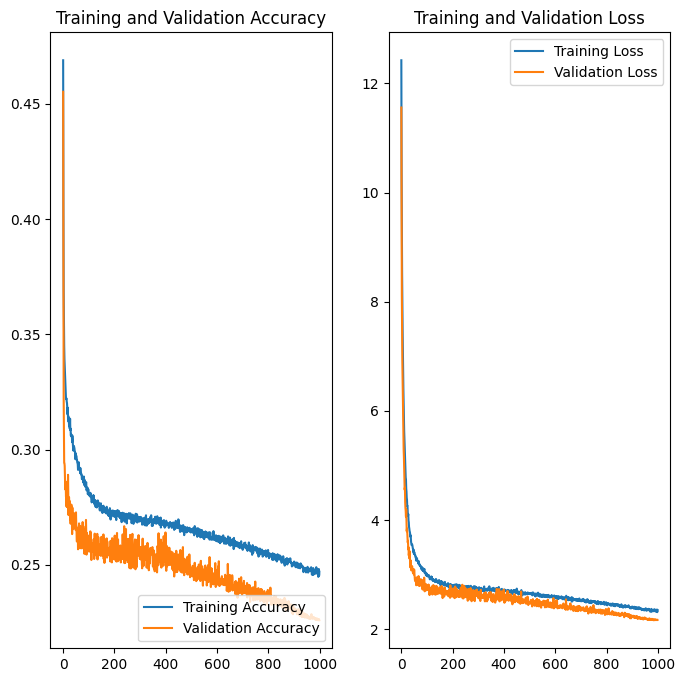

In [37]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

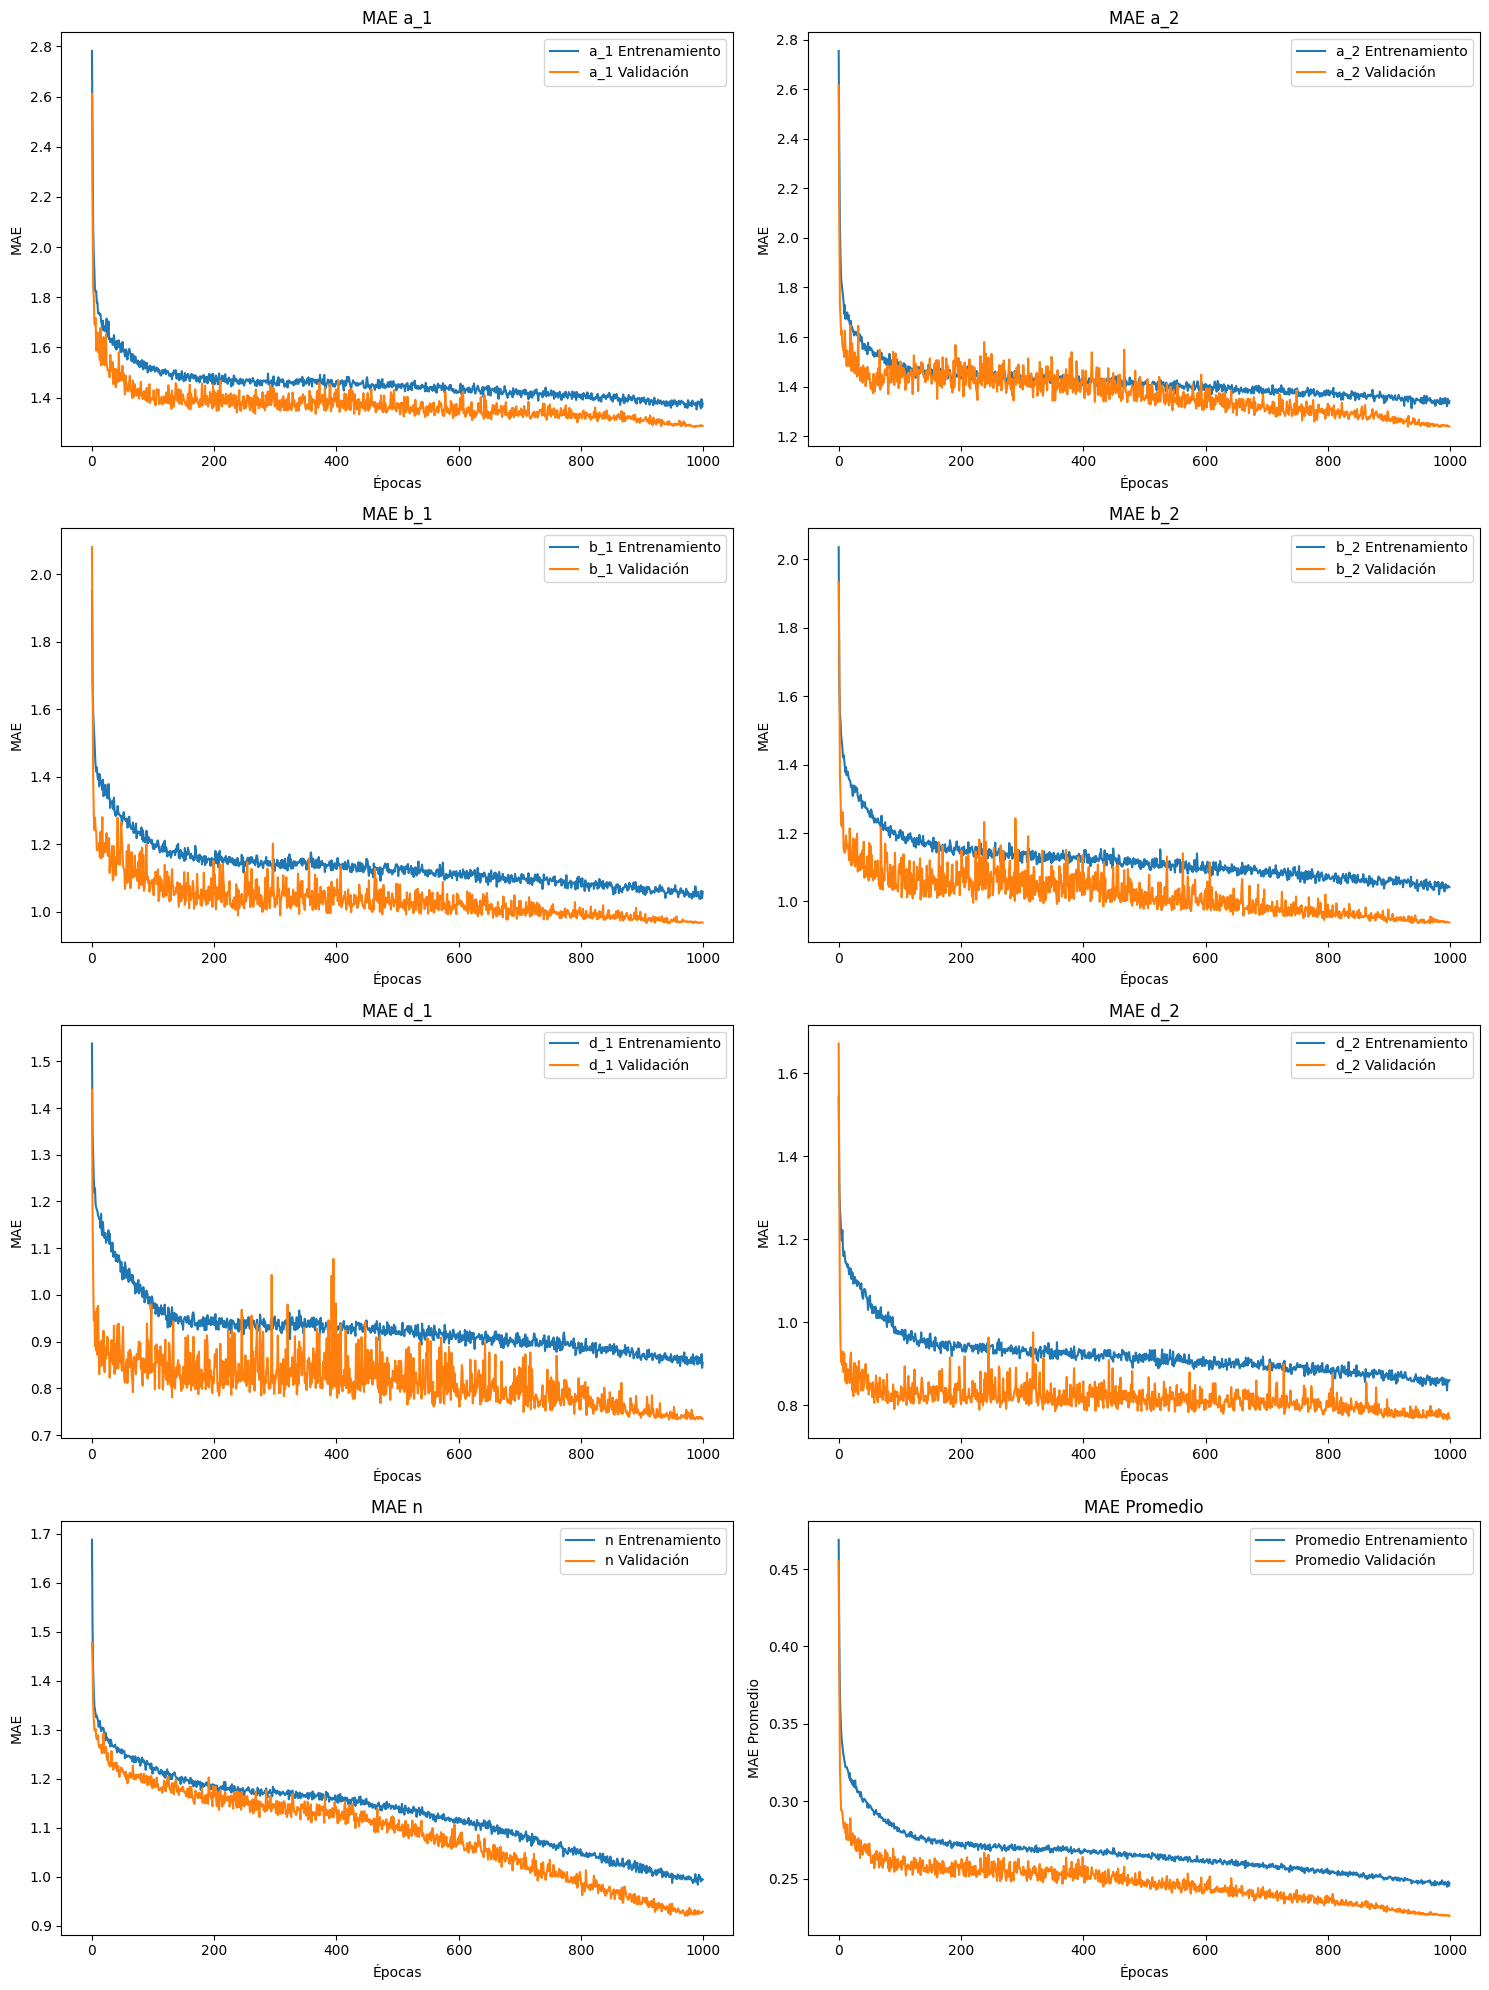

In [38]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [39]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

32/32 [==============================] - 0s 932us/step - loss: 2.2910 - a_1: 1.3486 - a_2: 1.3417 - b_1: 0.9687 - b_2: 0.9777 - d_1: 0.7513 - d_2: 0.7641 - n: 0.9328 - mean_metric: 0.2358


In [40]:
predictions = model.predict(campvectest)

32/32 [==============================] - 0s 739us/step


In [41]:
print(coefcampvectest[0,:])
print(predictions[0,:])
from sklearn.metrics import mean_absolute_error
print(np.sum(coefcampvectest, axis=-1))

mae1 = mean_absolute_error(coefcampvectest[0,:], predictions[0,:])
mae1

[ 4  8  1 10  8  7  4]
[3.136279  8.40989   0.9033482 8.331552  7.7926064 6.579548  3.472724 ]
[42 39 36 35 32 23 38 42 29 19 26 29 39 31 47 33 18 48 31 32 31 30 52 26
 31 37 41 23 20 33 35 36 30 42 32 37 35 34 34 38 35 32 31 39 37 33 31 39
 34 30 45 33 36 27 23 33 40 39 37 32 29 44 23 22 35 34 35 38 31 22 40 28
 25 15 33 19 31 37 47 26 38 37 26 26 31 28 37 30 34 25 25 47 38 24 47 18
 32 25 28 32 25 35 43 41 33 31 39 35 25 29 31 30 43 24 32 28 35 33 36 39
 31 29 29 41 32 44 19 28 31 37 36 39 24 28 26 40 28 34 27 20 34 34 28 35
 36 37 42 30 18 41 32 27 30 31 33 31 31 45 28 52 33 47 31 36 30 43 45 37
 30 29 46 45 25 30 42 17 33 37 30 30 27 30 25 34 13 23 16 21 37 32 33 26
 20 44 27 37 28 24 28 41 38 47 23 31 25 46 37 32 21 23 20 43 27 27 23 36
 24 21 40 36 28 46 48 31 38 37 45 35 30 32 42 33 39 24 24 27 44 27 36 30
 43 28 31 25 15 30 36 32 33 28 39 29 30 34 33 28 45 40 34 34 32 13 31 36
 29 34 31 36 26 34 33 39 27 26 36 38 37 24 36 37 32 24 31 40 46 29 44 39
 44 31 32 41 29 31 43 26 32 3

0.5991190161023822

In [42]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.0126326944742885, Desviación estándar del error: 1.4071433286279076, Error absoluto máximo: 7.563642501831055


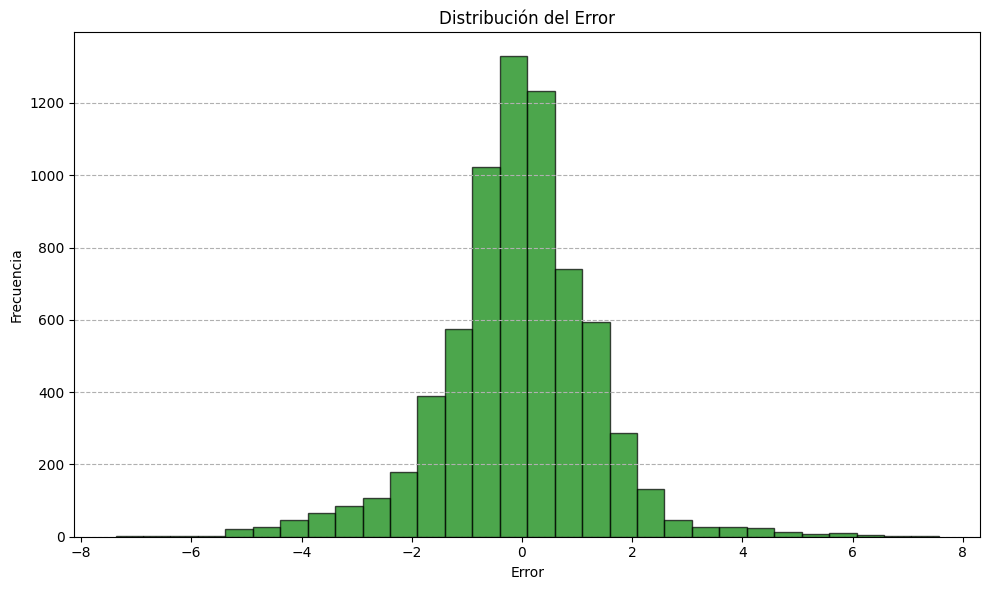

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [44]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.2484061504660872
Desviación estándar del error relativo: 0.22951154369580545
Error absoluto máximo relativo: 1.449272024134795


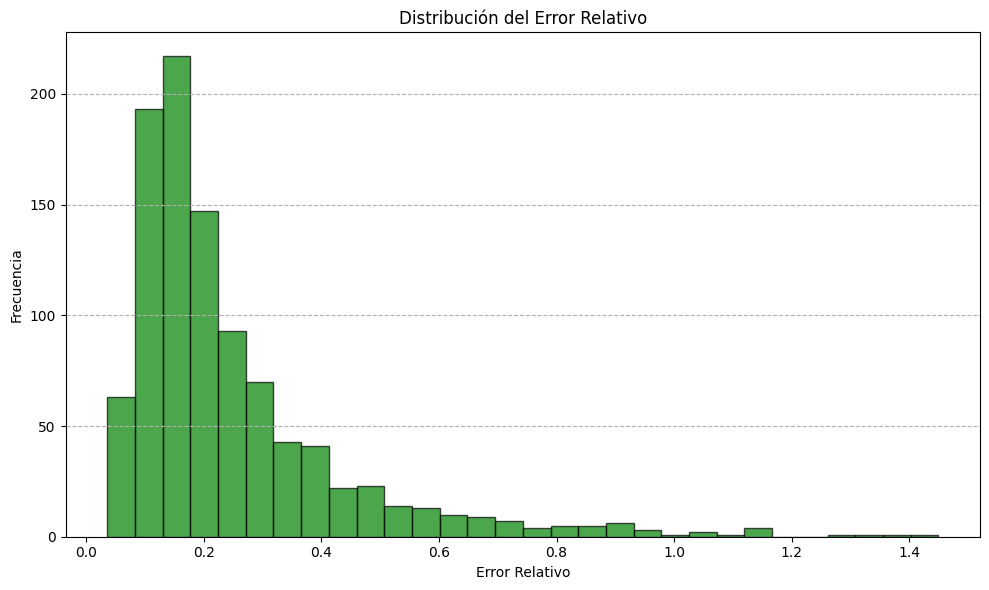

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos Accuracy y Loss

In [46]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/historycampvec20.csv', index=False)

# Guardamos el modelo

In [47]:
path_to_save = '../../../Modelos con ruido/Modelos 20,50'

In [48]:
model.save(path_to_save + '/campovectorial20.h5')

# Importamos el modelo

In [49]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [50]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [51]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation, 'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 20,50/campovectorial20.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [33]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)
    contador = contador+1
    print(contador)
    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[3, 8, 3, 4, 1, 5, 3]
1


In [34]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [35]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 59ms/step
[[4.9725375 4.866832  5.406149  5.1622105 1.50568   7.8840957 2.584898 ]]


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

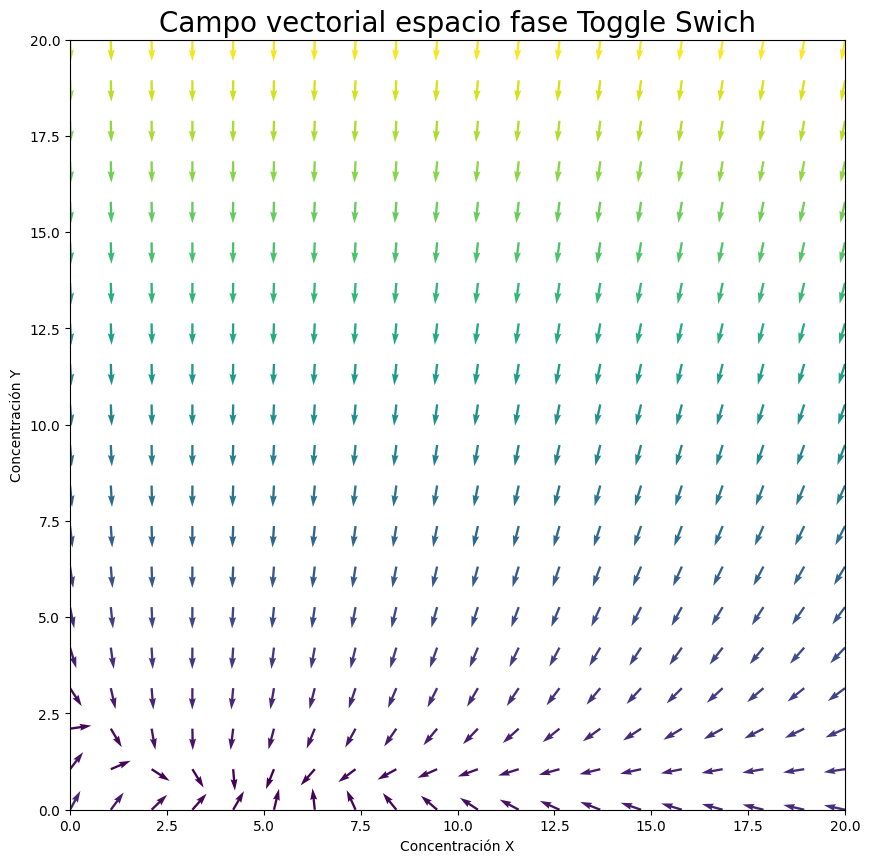

In [37]:
y1 = np.linspace(0, 10, 20)
y2 = np.linspace(0, 10, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

In [38]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

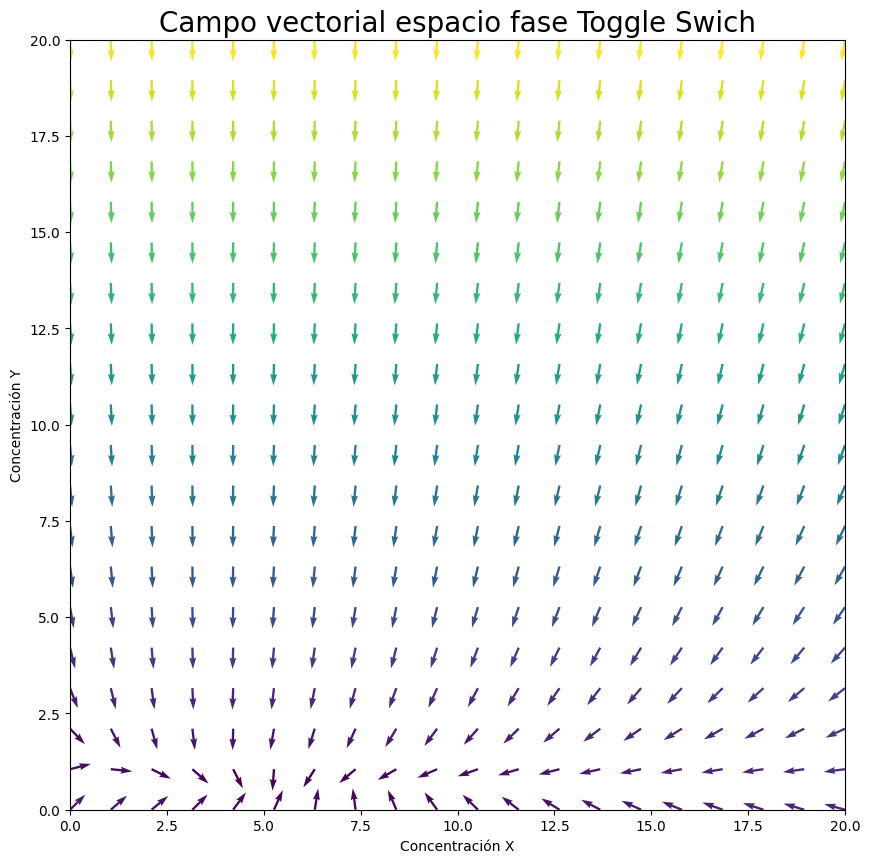

In [39]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]
 
def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1 = np.linspace(x_range_neg, x_range_pos, 20)
y2 = np.linspace(y_range_neg, y_range_pos, 20)

Y1, Y2 = np.meshgrid(y1, y2)
    
t1 = 0

u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape

u1, v1 = f(t1, [Y1, Y2])
u, v = f(t1, [Y1, Y2])
M = (np.hypot(u, v))
u /= M
v /= M
    
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')